# Detección de errores a partir de imágenes

## Exploración del dataset

Unión de carpetas para facilitar la división del dataset.

In [1]:
if False:
    import os
    import shutil

    # Ruta donde están las carpetas originales
    origen = "Imagenes_defectos"

    # Ruta de destino (una sola carpeta)
    destino = "dataset"

    # Crear carpeta destino si no existe
    os.makedirs(destino, exist_ok=True)

    # Recorrer todas las carpetas
    for carpeta in os.listdir(origen):
        ruta_carpeta = os.path.join(origen, carpeta)

        if os.path.isdir(ruta_carpeta):
            for imagen in os.listdir(ruta_carpeta):
                ruta_imagen = os.path.join(ruta_carpeta, imagen)

                if os.path.isfile(ruta_imagen):
                    nuevo_nombre = f"{carpeta}_{imagen}"
                    ruta_destino = os.path.join(destino, nuevo_nombre)

                    shutil.copy2(ruta_imagen, ruta_destino)

In [2]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

Formato del dataset para nuestro problema particular.

In [3]:
class RodamientoDataset(Dataset):
    def __init__(self, folder, img_tf=None, mask_tf=None):
        # Lista que almacena pares de imagen y máscara
        self.samples = []
        # Transformaciones para las imágenes
        self.img_tf = img_tf
        # Transformaciones para las máscaras
        self.mask_tf = mask_tf

        # Recorrer todos los archivos de la carpeta
        for f in os.listdir(folder):
            # Filtrar solo imágenes .jpg que no sean máscaras
            if f.endswith(".jpg") and "_label" not in f:
                img_path = os.path.join(folder, f)
                mask_path = os.path.join(folder, f.replace(".jpg", "_label.bmp"))
                # Verificar que la máscara exista antes de agregar
                if os.path.exists(mask_path):
                    self.samples.append((img_path, mask_path))

    def __len__(self):
        # Devuelve la cantidad de muestras
        return len(self.samples)

    def __getitem__(self, idx):
        # Obtener paths de la imagen y máscara
        img_path, mask_path = self.samples[idx]

        # Abrir la imagen y la máscara en escala de grises ('L')
        img = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        # Aplicar transformaciones si están definidas
        if self.img_tf:
            img = self.img_tf(img)
        if self.mask_tf:
            mask = self.mask_tf(mask)

        # Convertir máscara a tensor binario, asegura que el tipo sea float para PyTorch
        mask = (mask > 0).float()
        # Devolver la imagen y la máscara
        return img, mask


Transformaciones que se han aplicado a las imaganes y labels.

In [4]:
img_tf = transforms.Compose([
    # Redimensiona la imagen a 256x256 píxeles
    transforms.Resize((256, 256)),
    # Convierte la imagen a un tensor de PyTorch y normaliza a [0,1]
    transforms.ToTensor(),
])

mask_tf = transforms.Compose([
    # Redimensiona la máscara a 256x256 píxeles, usa interpolación
    # 'NEAREST' para no crear valores intermedios
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    # Convierte la máscara a tensor, valores en [0,1]
    transforms.ToTensor()
])

In [5]:
# Crear el dataset usando la carpeta 'dataset' y las transformaciones
# definidas
dataset = RodamientoDataset("dataset", img_tf, mask_tf)
# Crear un DataLoader para iterar sobre el dataset en mini-batches
loader = DataLoader(dataset, batch_size=8, shuffle=True)

In [6]:
# Obtener un batch de imágenes y máscaras
x, y = next(iter(loader))
# Verificar las dimensiones del batch
print(x.shape)
print(y.shape)

torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])


Ploteamos las imágenes para comprobar que estan bien.

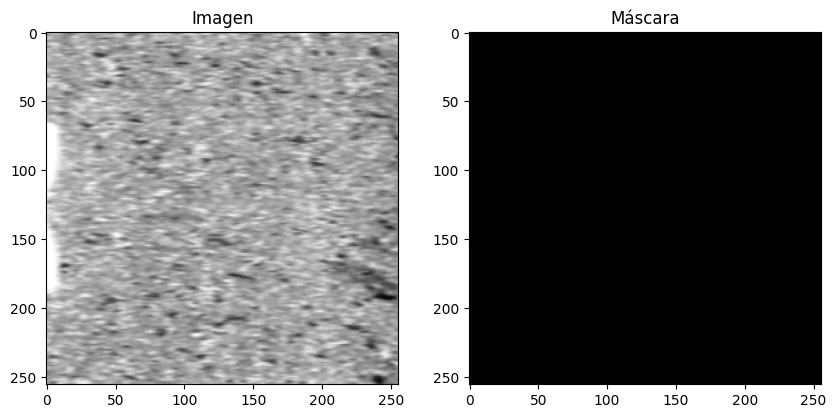

In [7]:
import matplotlib.pyplot as plt

img = x[0][0].numpy()
mask = y[0][0].numpy()

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title("Imagen")
plt.imshow(img, cmap='gray')

plt.subplot(1,2,2)
plt.title("Máscara")
plt.imshow(mask, cmap='gray')

plt.show()

Contar cantidad de imagenes de cada clase.

In [8]:
import numpy as np

count_0_pre = 0
count_1_pre = 0

for _, mask in dataset:
    mask_np = np.array(mask)
    if mask_np.sum() == 0:
        count_0_pre += 1
    else:
        count_1_pre += 1

print("Imágenes sin fallo:", count_0_pre)
print("Imágenes con fallo:", count_1_pre)

C:\Users\Izai\AppData\Local\Temp\ipykernel_10176\4027298600.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  mask_np = np.array(mask)


Imágenes sin fallo: 347
Imágenes con fallo: 52


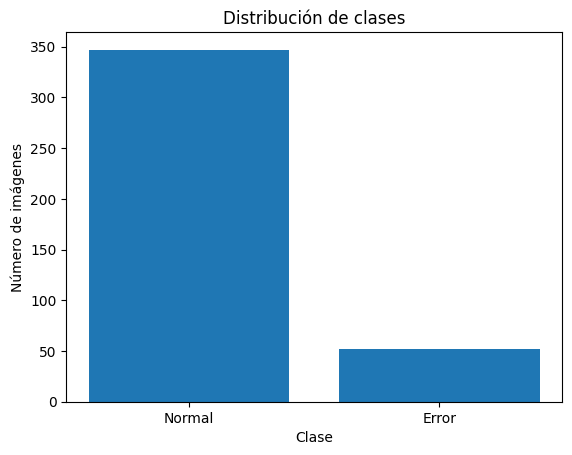

In [9]:
plt.bar(["Normal", "Error"], [count_0_pre, count_1_pre])
plt.title("Distribución de clases")
plt.xlabel("Clase")
plt.ylabel("Número de imágenes")
plt.show()

Claramente hay un desbalanceo de clases donde hay muchas menos imagenes con errores.

Seleccionamos solo las imágenes que contienen errores y creamos un dataset con ellas.

In [10]:
from torch.utils.data import Subset
fault_indices = [i for i in range(len(dataset)) if dataset[i][1].sum() > 0]
fault_dataset = Subset(dataset, fault_indices)

Bucle para ejecutar el data augmentation sobre las imágenes con errores.

In [11]:
import torchvision.transforms.functional as TF
import random

# Listas donde se almacenarán las imágenes y máscaras aumentadas
augmented_images = []
augmented_masks = []

# Recorrer todas las imágenes con errores
for img, mask in fault_dataset:
    # Generar 3 versiones aumentadas por cada imagen
    for _ in range(3):
        # Obtener parámetros aleatorios
        i, j, h, w = transforms.RandomResizedCrop.get_params(
            img, scale=(0.8, 1.0), ratio=(1.0, 1.0)  # ratio 1:1 para no deformar
        )
        
        # Aplicar crop y redimensionar a 256x256
        # Para la máscara usamos interpolación 'NEAREST' para no
        # interpolar valores
        new_img = TF.resized_crop(img, i, j, h, w, size=(256, 256))
        new_mask = TF.resized_crop(mask, i, j, h, w, size=(256, 256), interpolation=Image.NEAREST)

        # Binarizar la máscara después del crop (0 o 1)
        new_mask = (new_mask > 0).float()

        # Guardar las imágenes y máscaras aumentadas en las
        # listas
        augmented_images.append(new_img)
        augmented_masks.append(new_mask)


Proporción de clases después del data augmentation.

In [12]:
count_0_aug = 0
count_1_aug = 0

for mask in augmented_masks:
    if mask.sum() == 0:
        count_0_aug += 1
    else:
        count_1_aug += 1

print("Imágenes aumentadas sin fallo:", count_0_aug)
print("Imágenes aumentadas con fallo:", count_1_aug)

Imágenes aumentadas sin fallo: 0
Imágenes aumentadas con fallo: 156


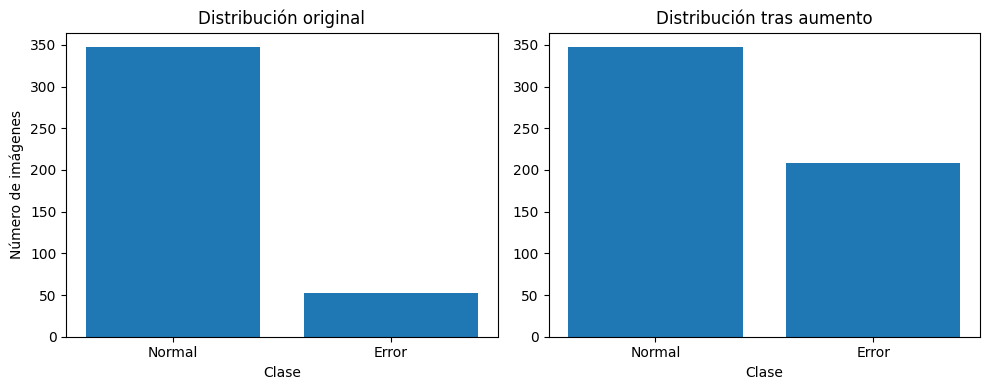

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].bar(["Normal", "Error"], [count_0_pre, count_1_pre])
axes[0].set_title("Distribución original")
axes[0].set_xlabel("Clase")
axes[0].set_ylabel("Número de imágenes")

axes[1].bar(
    ["Normal", "Error"],
    [count_0_pre + count_0_aug, count_1_pre + count_1_aug]
)
axes[1].set_title("Distribución tras aumento")
axes[1].set_xlabel("Clase")

plt.tight_layout()
plt.show()

Imágenes para visualizar los datos nuevos.

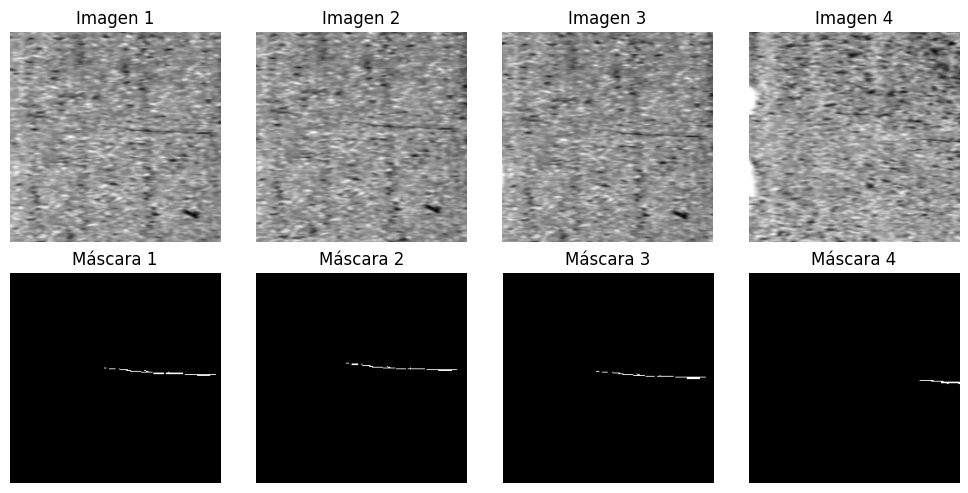

In [14]:
import matplotlib.pyplot as plt

num_to_show = 4
plt.figure(figsize=(10, 5))

for i in range(num_to_show):
    img = augmented_images[i]
    mask = augmented_masks[i]
    
    img_np = img[0].numpy()
    mask_np = mask[0].numpy()
    
    plt.subplot(2, num_to_show, i+1)
    plt.imshow(img_np, cmap='gray')
    plt.title(f"Imagen {i+1}")
    plt.axis('off')
    
    plt.subplot(2, num_to_show, i+1+num_to_show)
    plt.imshow(mask_np, cmap='gray')
    plt.title(f"Máscara {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


Concatenamos los dataset para tener todo en un único dataset.

In [15]:
from torch.utils.data import TensorDataset
from torch.utils.data import ConcatDataset

# Convertir las listas de imágenes y máscaras aumentadas en tensores
aug_imgs_tensor = torch.stack(augmented_images)
aug_masks_tensor = torch.stack(augmented_masks)

# Crear un TensorDataset con los datos aumentados
aug_dataset = TensorDataset(aug_imgs_tensor, aug_masks_tensor)

# ConcatDataset crea un dataset que actúa como si fuera uno solo
full_dataset = ConcatDataset([dataset, aug_dataset])

In [16]:
count_0 = 0
count_1 = 0

for img, mask in full_dataset:
    if mask.sum() == 0:
        count_0 += 1
    else:
        count_1 += 1

print("Total imágenes sin fallo:", count_0)
print("Total imágenes con fallo:", count_1)

Total imágenes sin fallo: 347
Total imágenes con fallo: 208


Creamos el label de la imagen revisando si hay algún pixel a color en la mascara.

In [17]:
# Listas donde guardaremos los datos
images_list = []
masks_list = []
labels_list = []

# Recorrer todo el dataset combinado

for img, mask in full_dataset:
    # Guardar imagen y máscara
    images_list.append(img)
    masks_list.append(mask)

    # Crear etiqueta binaria
    label = 1 if mask.sum() > 0 else 0
    labels_list.append(label)

# Convertimos a tensores
images_tensor = torch.stack(images_list)
masks_tensor = torch.stack(masks_list)
labels_tensor = torch.tensor(labels_list, dtype=torch.long)

Calculamos un peso proporcional a la cantidad de elementos en cada clase.

In [18]:
# Número de ejemplos positivos
num_pos = labels_tensor.sum()
# Número de ejemplos negativos
num_neg = len(labels_tensor) - num_pos

# Peso proporcional: queremos que los positivos tengan más peso si
# son minoría
pos_weight = num_neg / num_pos
# Convertimos a tensor para usar la función de pérdida
# (BCEWithLogitsLoss)
pos_weight_tensor = torch.tensor([pos_weight], dtype=torch.float32)
print(f"Pos weight: {pos_weight}")

Pos weight: 1.6682692766189575


Guardar el dataset en un archivo .pt para facil acceso.

In [19]:
# Listas para almacenar imágenes, máscaras y etiquetas
images_list = []
masks_list = []
labels_list = []

# Recorrer todo el dataset combinado
for img, mask in full_dataset:
    images_list.append(img)
    masks_list.append(mask)

    # Crear etiqueta binaria
    label = 1 if mask.sum() > 0 else 0
    labels_list.append(label)

# Convertir las listas a tensores de PyTorch
images_tensor = torch.stack(images_list)
masks_tensor = torch.stack(masks_list)
labels_tensor = torch.tensor(labels_list, dtype=torch.long)

# Guardar los tensores en un archivo .pt para cargar después
torch.save({
    'images': images_tensor,
    'masks': masks_tensor,
    'labels': labels_tensor
}, 'dataset_full_with_labels.pt')

print("Dataset guardado correctamente con images, masks y labels")

Dataset guardado correctamente con images, masks y labels


# Detección binaria utilizando ResNet

Como acceder al dataset actual.

In [20]:
# Cargar el dataset guardado previamente
data_res = torch.load('dataset_full_with_labels.pt')

# Extraer tensores de imágenes, máscaras y etiquetas
images_res = data_res['images']
masks_res = data_res['masks']
labels_res = data_res['labels']

# Repetir el canal de las imágenes de 1 a 3
images_res = images_res.repeat(1, 3, 1, 1)

# Crear un TensorDataset con imágenes, máscaras y etiquetas
full_dataset_res = TensorDataset(images_res, masks_res, labels_res)

# Crear DataLoader para iterar en mini-batches
loader_res = DataLoader(full_dataset_res, batch_size=8, shuffle=True)

# Obtener un batch de prueba
x, y, lbl = next(iter(loader_res))

# Imprimir la forma de los tensores y las etiquetas del batch
print(x.shape, y.shape, lbl)

torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256]) tensor([0, 0, 0, 1, 1, 1, 0, 0])


Separamos el dataset en conjuntos de entrenamiento, validación y testeo

In [21]:
from torch.utils.data import random_split

# Número total de muestras en el dataset combinado
N = len(full_dataset)

# Calcular tamaños de cada split
train_size = int(0.7 * N)
val_size   = int(0.15 * N)
test_size  = N - train_size - val_size

# Crear un generador con semilla fija para reproducibilidad
generator = torch.Generator().manual_seed(42)

# Dividir el dataset en train, val y test
train_dataset_res, val_dataset_res, test_dataset_res = random_split(
    full_dataset_res,
    [train_size, val_size, test_size],
    generator=generator
)

# Definir batch size
batch_size = 8

# Crear DataLoaders para cada split
train_loader_res = DataLoader(train_dataset_res, batch_size=batch_size, shuffle=True)
val_loader_res   = DataLoader(val_dataset_res, batch_size=batch_size, shuffle=False)
test_loader_res  = DataLoader(test_dataset_res, batch_size=batch_size, shuffle=False)

In [22]:
# Extraer los tensores de imágenes, máscaras y etiquetas
images_test = full_dataset_res.tensors[0][test_dataset_res.indices]
masks_test  = full_dataset_res.tensors[1][test_dataset_res.indices]
labels_test = full_dataset_res.tensors[2][test_dataset_res.indices]

# Guardar el dataset de test en un archivo .pt
torch.save({
    'images': images_test,
    'masks': masks_test,
    'labels': labels_test
}, "dataset_test.pt")

Cargamos el modelo resnet18 y congelamos los parámetros que no queremos entrenar.

In [23]:
import torch.nn as nn
from torchvision import models

# Cargar ResNet18 preentrenada en ImageNet
model_res = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
# Congelar todos los parámetros para que no se actualicen durante el
# entrenamiento
for param in model_res.parameters():
    param.requires_grad = False

# Reemplazar la capa fully connected (fc) para clasificación binaria
model_res.fc = nn.Linear(512, 1)

Confirmamos que los parámetros de la capa densa son entrenables.

In [24]:
for name, param in model_res.named_parameters():
    if param.requires_grad:
        print(name)

fc.weight
fc.bias


In [25]:
# Detectar si hay GPU disponible; si no, usar CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Mover el modelo a la GPU/CPU correspondiente
model_res.to(device)

# Definir la función de pérdida para clasificación binaria con
# desbalance de clases
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor.to(device))
# Definir optimizador (Adam) solo para los parámetros de la capa fc
# porque el resto de la red está congelado
optimizer = torch.optim.Adam(model_res.fc.parameters(), lr=1e-4)

Funciones auxiliares para el entrenamiento.

In [26]:
def train_one_epoch_res(model, loader, optimizer, criterion, device):
    # Modo entrenamiento
    model.train()
    # Acumulador de pérdida
    running_loss = 0.0

    # Iterar sobre todos los batches
    for images, _, labels in loader:
        # Mover imágenes a GPU/CPU
        images = images.to(device)
        # Convertir a float y reshaping [batch, 1]
        labels = labels.float().view(-1, 1).to(device)

        # Limpiar gradientes previos
        optimizer.zero_grad()
        # logits
        outputs = model(images)
        # Calcular pérdida
        loss = criterion(outputs, labels)
        # Backpropagation
        loss.backward()
        # Actualizar parámetros
        optimizer.step()
        # Sumar pérdida del batch
        running_loss += loss.item()
    # Retornar pérdida promedio por batch
    return running_loss / len(loader)

In [27]:
def validate_res(model, loader, criterion, device):
    # Modo evaluación
    model.eval()
    running_loss = 0.0
    # Contadores para métricas de clasificación
    # True positives
    tp = 0
    # False positives
    fp = 0
    # False negatives
    fn = 0

    # No calcular gradientes durante validación
    with torch.no_grad():
        for images, _, labels in loader:
            images = images.to(device)
            labels = labels.float().view(-1, 1).to(device)

            # Forward
            outputs = model(images)   # logits
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Probabilidades y predicciones
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).int()

            # TP, FP, FN
            tp += ((preds == 1) & (labels == 1)).sum().item()
            fp += ((preds == 1) & (labels == 0)).sum().item()
            fn += ((preds == 0) & (labels == 1)).sum().item()

    # Métricas
    precision = tp / (tp + fp + 1e-8)
    recall    = tp / (tp + fn + 1e-8)
    f1        = 2 * precision * recall / (precision + recall + 1e-8)

    return running_loss / len(loader), f1


Bucle principal de entrenamiento.

In [28]:
# Número de épocas a entrenar
num_epochs = 20

# Listas para almacenar métricas por época
train_losses_res = []
val_losses_res = []
val_f1s_res = []

# Loop principal de entrenamiento
for epoch in range(num_epochs):
    # Entrenar el modelo durante una época
    train_loss_res = train_one_epoch_res(
        model_res, train_loader_res, optimizer, criterion, device
    )
    # validar el modelo
    val_loss_res, val_f1_res = validate_res(
        model_res, val_loader_res, criterion, device
    )

    # Guardar las métricas
    train_losses_res.append(train_loss_res)
    val_losses_res.append(val_loss_res)
    val_f1s_res.append(val_f1_res)
    # Imprimir métricas
    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {train_loss_res:.4f} | "
        f"Val Loss: {val_loss_res:.4f} | "
        f"Val f1-score: {val_f1_res:.4f}"
    )

Epoch 1/20 | Train Loss: 0.8833 | Val Loss: 0.9699 | Val f1-score: 0.2273
Epoch 2/20 | Train Loss: 0.8527 | Val Loss: 0.8902 | Val f1-score: 0.3947
Epoch 3/20 | Train Loss: 0.8281 | Val Loss: 0.8134 | Val f1-score: 0.5783
Epoch 4/20 | Train Loss: 0.8059 | Val Loss: 0.7982 | Val f1-score: 0.6076
Epoch 5/20 | Train Loss: 0.7790 | Val Loss: 0.7663 | Val f1-score: 0.6818
Epoch 6/20 | Train Loss: 0.7657 | Val Loss: 0.7307 | Val f1-score: 0.7013
Epoch 7/20 | Train Loss: 0.7401 | Val Loss: 0.7194 | Val f1-score: 0.7568
Epoch 8/20 | Train Loss: 0.7310 | Val Loss: 0.6918 | Val f1-score: 0.7381
Epoch 9/20 | Train Loss: 0.7113 | Val Loss: 0.6809 | Val f1-score: 0.7429
Epoch 10/20 | Train Loss: 0.6913 | Val Loss: 0.6706 | Val f1-score: 0.7561
Epoch 11/20 | Train Loss: 0.6869 | Val Loss: 0.6545 | Val f1-score: 0.7887
Epoch 12/20 | Train Loss: 0.6948 | Val Loss: 0.6383 | Val f1-score: 0.8116
Epoch 13/20 | Train Loss: 0.6709 | Val Loss: 0.6338 | Val f1-score: 0.7941
Epoch 14/20 | Train Loss: 0.6714 |

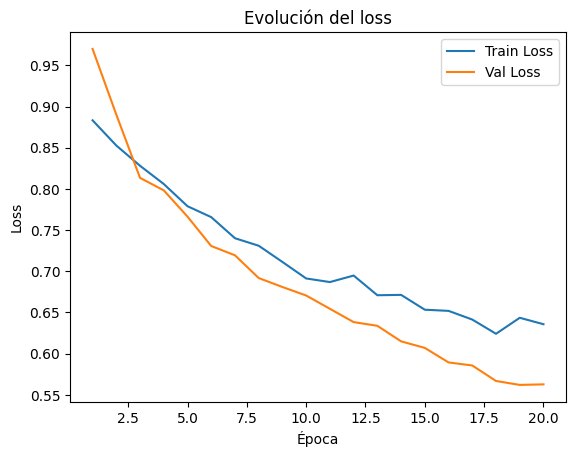

In [29]:
# Crear un rango de números para las épocas
epochs = range(1, num_epochs + 1)

# Graficar la pérdida de entrenamiento
plt.plot(epochs, train_losses_res, label="Train Loss")

# Graficar la pérdida de validación
plt.plot(epochs, val_losses_res, label="Val Loss")

plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Evolución del loss")
plt.legend()
plt.show()

Valor de la función de perdida y f1-score en el test set.

In [30]:
# Evaluar el mdoelo en el DataLoader de test
test_loss_res, test_f1_res = validate_res(model_res, test_loader_res, criterion, device)

# Imprimir resultados finales de test
print(f"Test Loss: {test_loss_res:.4f} | Test F1: {test_f1_res:.4f}")

Test Loss: 0.5639 | Test F1: 0.8077


Guardamos el modelo en un archivo pkl y pth.

In [31]:
import joblib
joblib.dump(model_res, "Image_model_res.pkl")
torch.save(model_res.state_dict(), 'model_res_weights.pth')
print("Modelo guardado en 'Image_model_res.pkl' y 'model_res_weights.pth'")

Modelo guardado en 'Image_model_res.pkl' y 'model_res_weights.pth'


# Detección binaria utilizando un modelo propio.

In [50]:
# Cargar el dataset completo previamente guardado
data_custom = torch.load("dataset_full_with_labels.pt")

# Extraer los tensores de imágenes y etiquetas
images_custom = data_custom["images"]
labels_custom = data_custom["labels"]

In [51]:
from torch.utils.data import Dataset

# Crear un Dataset personalizado que recibe tensores de imágenes y labels
class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        # Devuelve el número de muestras
        return len(self.labels)

    def __getitem__(self, idx):
        # Devuelve la imagen y etiqueta correspondientes al índice idx
        return self.images[idx], self.labels[idx]
# Crear una instancia del dataset con los datos
dataset_custom = ImageDataset(images_custom, labels_custom)

In [52]:
from torch.utils.data import random_split, DataLoader

# Número total de muestras en el dataset custom
N = len(dataset_custom)

# Calcular tamaños de train, val y test
train_size = int(0.7 * N)
val_size   = int(0.15 * N)
# Nos aseguramos que la suma sea N
test_size  = N - train_size - val_size

# Crear un generador con semilla fija para reproducibilidad
generator = torch.Generator().manual_seed(42)

# Dividir el dataset en train, val y test
train_dataset_custom, val_dataset_custom, test_dataset_custom = random_split(
    dataset_custom,
    [train_size, val_size, test_size],
    generator=generator
)

# Definir tamaño de batch
batch_size = 8

# Crear DataLoaders para cada split
train_loader_custom = DataLoader(train_dataset_custom, batch_size=batch_size, shuffle=True)
val_loader_custom = DataLoader(val_dataset_custom, batch_size=batch_size, shuffle=False)
test_loader_custom = DataLoader(test_dataset_custom, batch_size=batch_size, shuffle=False)

In [53]:
# Obtener el primer batch del DataLoader de entrenamiento
x, y = next(iter(train_loader_custom))
# Imprimir la forma del tensor de imágenes
print(x.shape)

torch.Size([8, 1, 256, 256])


In [54]:
import torch.nn as nn

class DefectCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Bloques convolucionales con BatchNorm + ReLU + MaxPool
        self.features = nn.Sequential(
            # Primer bloque
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Segundo bloque
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            #Tercer bloque
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Cuarto bloque
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        # Pooling adaptativo para obtener tamaño fijo 1x1
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        # Capa final para clasificación binaria
        self.classifier = nn.Linear(256, 1)

    def forward(self, x):
        # Paso por bloques convolucionales
        x = self.features(x)
        # Pooling adaptativo
        x = self.pool(x)
        # Aplanar para la capa fully connected
        x = x.view(x.size(0), -1)
        # Clasificación final
        x = self.classifier(x)
        return x

In [55]:
# Detectar si hay GPU disponible; si no, usar CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando:", device)

# Crear instancia del modelo y moverla a GPU/CPU
model_custom = DefectCNN().to(device)

# Definir la función de pérdida para clasificación binaria
criterion_custom = nn.BCEWithLogitsLoss()
# Definir optimizador Adam para todos los parámetros del modelo
optimizer_custom = torch.optim.Adam(model_custom.parameters(), lr=1e-5)

Usando: cpu


In [56]:
def train_one_epoch_custom(model, loader, optimizer, criterion):
    # Modo entrenamiento
    model.train()
    # Acumulador de pérdida
    running_loss = 0.0
    # Iterar sobre todos los batches
    for images, labels in loader:
        # Mover datos a GPU/CPU
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        # Limpiar gradientes previos
        optimizer.zero_grad()

        outputs = model(images)
        # Calcular pérdida
        loss = criterion(outputs, labels)
        # Backpropagation
        loss.backward()
        # Actualizar parámetros
        optimizer.step()
        # Acumular pérdida del batch
        running_loss += loss.item()
    # Retornar pérdida promedio
    return running_loss / len(loader)

In [57]:
def validate_custom(model, loader, criterion, device):
    # Modo evaluación
    model.eval()
    running_loss = 0.0
    # Inicializar contadores para métricas
    tp = 0
    fp = 0
    fn = 0
    # No calcular gradientes en validación
    with torch.no_grad():
        for images, labels in loader:
            # Mover datos al dispositivo
            images = images.to(device)
            labels = labels.float().view(-1, 1).to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Convertir Logits a probabilidades y binarizar
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).int()

            # Contar TP, FP y FN
            tp += ((preds == 1) & (labels == 1)).sum().item()
            fp += ((preds == 1) & (labels == 0)).sum().item()
            fn += ((preds == 0) & (labels == 1)).sum().item()

    # Calcular métricas
    precision = tp / (tp + fp + 1e-8)
    recall    = tp / (tp + fn + 1e-8)
    f1        = 2 * precision * recall / (precision + recall + 1e-8)

    return running_loss / len(loader), f1

In [58]:
# Número total de épocas de entrenamiento
num_epochs = 20

# Listas para guardar las métricas de cada época
train_losses_custom = []
val_losses_custom = []
val_f1s_custom = []

# Bucle princiñal de entrenamiento
for epoch in range(num_epochs):
    # Entrena el modelo durante una época completa
    train_loss_custom = train_one_epoch_custom(
        model_custom, train_loader_custom, optimizer_custom, criterion_custom
    )
    # Evalúa el modelo en el conjunto de validación
    val_loss_custom, val_f1score_custom = validate_custom(
        model_custom, val_loader_custom, criterion_custom, device
    )
    # Guardar métricas de la época
    train_losses_custom.append(train_loss_custom)
    val_losses_custom.append(val_loss_custom)
    val_f1s_custom.append(val_f1score_custom)
    # Mostrar resultaados de la época actual
    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {train_loss_custom:.4f} | "
        f"Val Loss: {val_loss_custom:.4f} | "
        f"Val F1-score: {val_f1score_custom:.4f}"
    )

Epoch 1/20 | Train Loss: 0.6671 | Val Loss: 0.7853 | Val F1-score: 0.5812
Epoch 2/20 | Train Loss: 0.6326 | Val Loss: 0.6221 | Val F1-score: 0.5312
Epoch 3/20 | Train Loss: 0.6116 | Val Loss: 0.6033 | Val F1-score: 0.5538
Epoch 4/20 | Train Loss: 0.5894 | Val Loss: 0.5912 | Val F1-score: 0.6757
Epoch 5/20 | Train Loss: 0.5718 | Val Loss: 0.5771 | Val F1-score: 0.6757
Epoch 6/20 | Train Loss: 0.5533 | Val Loss: 0.5582 | Val F1-score: 0.6957
Epoch 7/20 | Train Loss: 0.5575 | Val Loss: 0.5400 | Val F1-score: 0.6567
Epoch 8/20 | Train Loss: 0.5476 | Val Loss: 0.5289 | Val F1-score: 0.7143
Epoch 9/20 | Train Loss: 0.5202 | Val Loss: 0.5148 | Val F1-score: 0.7143
Epoch 10/20 | Train Loss: 0.5234 | Val Loss: 0.5035 | Val F1-score: 0.7143
Epoch 11/20 | Train Loss: 0.5048 | Val Loss: 0.4770 | Val F1-score: 0.7077
Epoch 12/20 | Train Loss: 0.4925 | Val Loss: 0.4639 | Val F1-score: 0.7463
Epoch 13/20 | Train Loss: 0.4935 | Val Loss: 0.4541 | Val F1-score: 0.7536
Epoch 14/20 | Train Loss: 0.4777 |

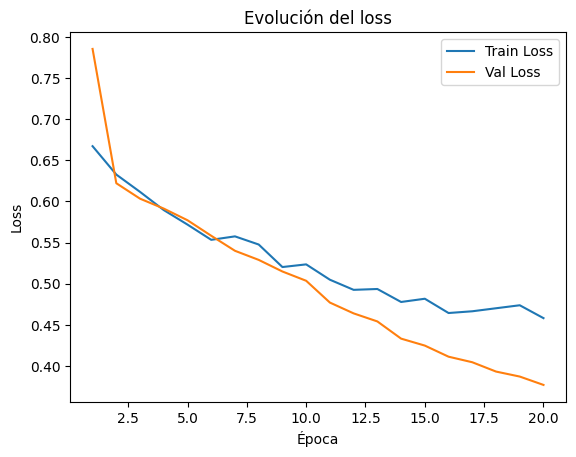

In [59]:
# Crear un rango de épocas para el eje X del gráfico
epochs = range(1, num_epochs + 1)

# Graficar la pérdida de entrenamiento por época
plt.plot(epochs, train_losses_custom, label="Train Loss")
# Graficar la pérdida de validación por época
plt.plot(epochs, val_losses_custom, label="Val Loss")

plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Evolución del loss")
plt.legend()
plt.show()

In [60]:
# Evaluar el modelo entrenado en el conjunto de test
test_loss_custom, test_f1_custom = validate_custom(model_custom, test_loader_custom, criterion_custom, device)
# Mostrar los resultados finales en test
print(f"Test Loss: {test_loss_custom:.4f} | " f"Test F1: {test_f1_custom:.4f}")

Test Loss: 0.4134 | Test F1: 0.7500


In [42]:
# Guardar el modelo completo usando joblib
joblib.dump(model_custom, "Image_model_custom.pkl")
# Guardar solo los pesos del modelo con PyTorch
torch.save(model_custom.state_dict(), 'model_custom_weights.pth')
# Confirmación por pantalla
print("Modelo guardado en 'Image_model_custom.pkl' y 'model_custom_weights.pth'")

Modelo guardado en 'Image_model_custom.pkl' y 'model_custom_weights.pth'


## YOLO para la localización del error

Preparamos el conjunto de datos para utilizar correctamente el modelo YOLO ya que necesita las imagenes en formato .jpg directamente.

In [1]:
import os
import shutil
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

def prepare_yolo_dataset(dataset_dir, output_dir, val_ratio=0.2, random_state=42):
    # Crear carpeta raíz de salida si no existe
    os.makedirs(output_dir, exist_ok=True)

    # Crear estructura de carpetas requerida por YOLO
    for folder in ["images/train", "images/val", "labels/train", "labels/val"]:
        os.makedirs(os.path.join(output_dir, folder), exist_ok=True)

    # Crear una lista con los nombres de todos los archivos .jpg que hay
    # en la carpeta del dataset.
    all_images = [f for f in os.listdir(dataset_dir) if f.lower().endswith(".jpg")]

    # Dividir imágenes en train y validation
    train_imgs, val_imgs = train_test_split(all_images, test_size=val_ratio, random_state=random_state)
    
    def process_set(img_list, subset):
        for img_name in img_list:
            # Rutas de imagen y máscara
            img_path = os.path.join(dataset_dir, img_name)
            mask_name = img_name.replace(".jpg", "_label.bmp")
            mask_path = os.path.join(dataset_dir, mask_name)

            # Copiar imagen a carpeta YOLO
            shutil.copy(img_path, os.path.join(output_dir, f"images/{subset}", img_name))

            # Carfar máscara en escala de grises
            mask = Image.open(mask_path).convert("L")
            mask_np = np.array(mask)

            # Ruta del archivo de etiquetas YOLO (.txt)
            txt_path = os.path.join(output_dir, f"labels/{subset}", img_name.replace(".jpg", ".txt"))

            # Si no hay defecto, crear archivo vacío
            if mask_np.sum() == 0:
                with open(txt_path, "w") as f:
                    pass
                continue

            # Obtener coordenadas donde hay defecto
            ys, xs = np.where(mask_np > 0)
            x_min, x_max = xs.min(), xs.max()
            y_min, y_max = ys.min(), ys.max()

            # Convertir bounding box a formato YOLO (normalizado)
            x_center = (x_min + x_max) / 2 / mask_np.shape[1]
            y_center = (y_min + y_max) / 2 / mask_np.shape[0]
            width = (x_max - x_min) / mask_np.shape[1]
            height = (y_max - y_min) / mask_np.shape[0]

            # Escribir archivo YOLO
            with open(txt_path, "w") as f:
                f.write(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

    # Procesar conjuntos de entrenamiento y validación
    process_set(train_imgs, "train")
    process_set(val_imgs, "val")

    # Mensajes finales
    print("YOLO dataset creado en:", output_dir)
    print(f"Train: {len(train_imgs)} imágenes, Val: {len(val_imgs)} imágenes")


In [2]:
prepare_yolo_dataset("dataset", "yolo_dataset", val_ratio=0.2)

YOLO dataset creado en: yolo_dataset
Train: 319 imágenes, Val: 80 imágenes


Entrenamos el modelo yolo con nuestras imagenes de entrenamiento.

In [4]:
from ultralytics import YOLO

# Cargar el modelo YOLOv8 preentrenado
model_yolo = YOLO("yolov8n.pt")

# Entrenar el mdoelo en el dataset YOLO
results = model_yolo.train(
    data="yolo_dataset.yaml",
    epochs=20,
    imgsz=256,
    batch=8,
    lr0=1e-3,
    project="yolo_defect",
    name="defect_detection",
    exist_ok=True
)

New https://pypi.org/project/ultralytics/8.4.6 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.252  Python-3.12.10 torch-2.9.1+cpu CPU (Intel Core Ultra 7 255U)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=defect_detection, nbs=64, nms=False, opset=None, opti

Predecimos donde esta el error usando el modelo YOLO. (Prueba)

In [5]:
from ultralytics import YOLO

# Cargar el modelo YOLO entrenado con nuestros propios pesos
model_yolo.yolo = YOLO(
    r"C:\Users\Izai\Desktop\Work\Master\Reto2\yolo_defect\defect_detection\weights\best.pt"
)
# Ruta de la iamgen que queremos analizar
img_path_yolo = r"C:\Users\Izai\Desktop\Work\Master\Reto2\dataset\kos01_Part5.jpg"

# Realizamos la predicción sobre la imagen
results = model_yolo.predict(
    source=img_path_yolo,
    conf=0.2,
    save=True,
    show=True
)


image 1/1 C:\Users\Izai\Desktop\Work\Master\Reto2\dataset\kos01_Part5.jpg: 256x128 (no detections), 23.8ms
Speed: 1.0ms preprocess, 23.8ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 128)
Results saved to C:\Users\Izai\Desktop\Work\Master\Reto2\runs\detect\predict18
